# STA LTA for BSPF only

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [27]:
config = {}

config['seeds'] = {"rotation":"PY.BSPF..HJ*", "translation1":"II.PFO.10.BH*", "translation2":"PY.PFOIX..HH*"}

config['tbeg'] = obs.UTCDateTime("2022-10-03 16:00:00")
config['tend'] = obs.UTCDateTime("2022-10-03 17:00:00")

# config['tbeg'] = obs.UTCDateTime("2022-10-28 12:00:00")
# config['tend'] = obs.UTCDateTime("2022-10-28 16:00:00")

# config['tbeg'] = obs.UTCDateTime("2022-12-31 11:00:00")
# config['tend'] = obs.UTCDateTime("2022-12-31 15:00:00")


config['output_path'] = data_path+"BSPF/data/"

config['client'] = Client("IRIS")

## Load Data

In [28]:
from functions.request_data import __request_data

In [29]:
# if config['tbeg'] < obs.UTCDateTime("2023-04-01"):
#     st_xpfo, inv_xpfo = __request_data(config['seeds']['translation1'], config['tbeg'], config['tend'])
# else:
#     st_xpfo, inv_xpfo = __request_data(config['seeds']['translation2'], config['tbeg'], config['tend'])
    
# st_xpfo.detrend("linear")

In [30]:
st_bspf, inv_bspf = __request_data(config['seeds']['rotation'], config['tbeg'], config['tend'])

 -> sensitivity removed!


In [31]:
st_bspf = st_bspf.detrend("linear")

if len(st_bspf) > 3:
    st_bspf = st_bspf.merge(fill_value=0)

In [32]:
st_bspf

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-10-03T15:59:00.002300Z - 2022-10-03T17:00:59.997300Z | 200.0 Hz, 744000 samples
PY.BSPF..HJN | 2022-10-03T15:59:00.002300Z - 2022-10-03T17:00:59.997300Z | 200.0 Hz, 744000 samples
PY.BSPF..HJZ | 2022-10-03T15:59:00.002300Z - 2022-10-03T17:00:59.997300Z | 200.0 Hz, 744000 samples

## Process Data

In [ ]:
# st_xpfo_proc = st_xpfo.copy()
# # st_xpfo_proc = st_xpfo_proc.remove_response(inventory=inv_xpfo, output="ACC")

# st_bspf_proc = st_bspf.copy()
# # st_bspf_proc = st_bspf_proc.remove_sensitivity(inventory=inv_bspf)

# if config['tbeg'] < obs.UTCDateTime("2023-04-01"):
#     st_bspf_proc = st_bspf_proc.resample(40.0)


# st_xpfo_proc = st_xpfo_proc.normalize(global_max=False)
# st_bspf_proc = st_bspf_proc.normalize(global_max=False)

In [ ]:
# st = obs.Stream()

# st += st_bspf_proc.copy()
# st += st_xpfo_proc.copy()

# st.detrend("linear")
# st.taper(0.01)
# st.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=4, zerophase=True)  # optional prefiltering

In [ ]:
# st_bspf.plot(equal_scale=False);

## Launch Trigger

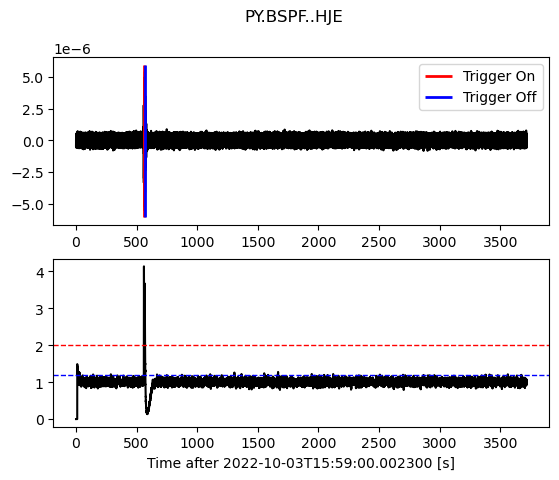

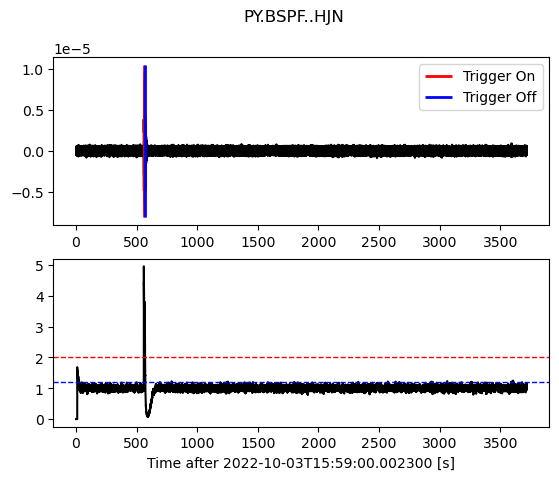

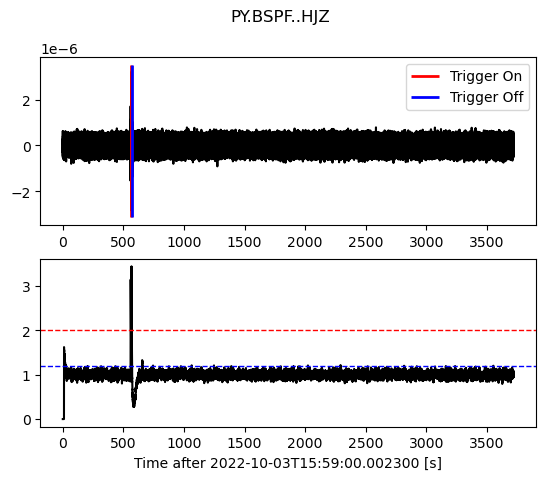

In [33]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset, plot_trigger
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

st = st_bspf.copy()

st = st.sort()

st.filter("highpass", freq=0.01, corners=4, zerophase=True)

# st = st.normalize(global_max=True)

df = st[0].stats.sampling_rate

config['trigger_type'] = 'recstalta'
config['thr_on'] = 2.0  ## thr_on (float) – threshold for switching single station trigger on
config['thr_off'] = 1.2 ## thr_off (float) – threshold for switching single station trigger off
config['lta'] = 10  ## seconds
config['sta'] = 1.5  ## seconds
config['thr_coincidence_sum'] = 1
# config['similarity_thresholds'] = {"BSPF": 0.5, "PFO": 0.5}


for ii, tr in enumerate(st):
    
    cft = recursive_sta_lta(tr.data, int(config['sta']*df), int(config['lta']*df))

    on_off = trigger_onset(cft, config['thr_on'], config['thr_off'])

    plot_trigger(tr, cft, config['thr_on'], config['thr_off'])

In [34]:
st.merge()
pprint(config)

trig = coincidence_trigger(config['trigger_type'],
                           config['thr_on'],
                           config['thr_off'],
                           stream = st, 
                           thr_coincidence_sum = config['thr_coincidence_sum'], 
                           sta=config['sta'], 
                           lta=config['lta'],
#                            similarity_threshold=config['similarity_thresholds'],
                          )

pprint(trig), len(trig)

{'client': <obspy.clients.fdsn.client.Client object at 0x7fc7b5333c90>,
 'lta': 10,
 'output_path': '/home/andbro/kilauea-data/BSPF/data/',
 'seeds': {'rotation': 'PY.BSPF..HJ*',
           'translation1': 'II.PFO.10.BH*',
           'translation2': 'PY.PFOIX..HH*'},
 'sta': 1.5,
 'tbeg': UTCDateTime(2022, 10, 3, 16, 0),
 'tend': UTCDateTime(2022, 10, 3, 17, 0),
 'thr_coincidence_sum': 1,
 'thr_off': 1.2,
 'thr_on': 2.0,
 'trigger_type': 'recstalta'}
[{'coincidence_sum': 3.0,
  'duration': 12.575000047683716,
  'similarity': {},
  'stations': ['BSPF', 'BSPF', 'BSPF'],
  'time': UTCDateTime(2022, 10, 3, 16, 8, 19, 372300),
  'trace_ids': ['PY.BSPF..HJN', 'PY.BSPF..HJE', 'PY.BSPF..HJZ']}]


(None, 1)

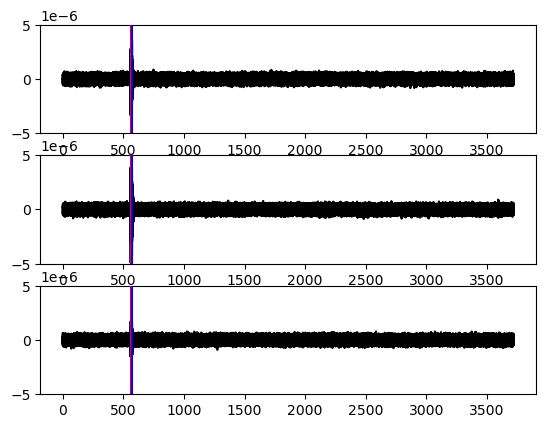

In [40]:
fig, ax = plt.subplots(3,1)

for i, tr in enumerate(st):
    ax[i].plot(tr.times(), tr.data, 'k', zorder=2)
    
    ttt = tl['time']-tr.stats.starttime
    for tl in trig:
        ax[i].axvline(ttt, color='r', zorder=5)
        ax[i].axvline(ttt+tl['duration'], color='b', zorder=5)
        
    ax[i].set_ylim(-5e-6,5e-6)


In [ ]:
# from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader

# date1 = obs.UTCDateTime("2022-12-31")
# date2 = obs.UTCDateTime("2023-01-01")

# mdl = MassDownloader()

# domain = CircularDomain(latitude=33.610643, longitude=-116.455439,
#                         minradius=0.0, maxradius=10.0)

# restrictions = Restrictions(
#     # Get data from 5 minutes before the event to one hour after the
#     # event. This defines the temporal bounds of the waveform data.
#     starttime=date1,
#     endtime=date2,
#     # You might not want to deal with gaps in the data. If this setting is
#     # True, any trace with a gap/overlap will be discarded.
#     reject_channels_with_gaps=False,
#     # And you might only want waveforms that have data for at least 95 % of
#     # the requested time span. Any trace that is shorter than 95 % of the
#     # desired total duration will be discarded.
#     minimum_length=0.9,
#     # No two stations should be closer than 10 km to each other. This is
#     # useful to for example filter out stations that are part of different
#     # networks but at the same physical station. Settings this option to
#     # zero or None will disable that filtering.
#     minimum_interstation_distance_in_m=10,
#     network="PY", station="BSPF", location="", channel="HJ*",
# )



# # The data will be downloaded to the ``./waveforms/`` and ``./stations/``
# # folders with automatically chosen file names.

# mdl.download(domain, 
#              restrictions, 
#              mseed_storage="waveforms",
#              stationxml_storage="stations"
#             )

In [ ]:
client = Client("IRIS")

t1 = config['tbeg']
st = obs.Stream()
while t1 <= config['tend']:
    t2 = t1 + 3600
    
    bulk = [("PY", "BSPF", "", "HJ*", t1, t2)]

    st += client.get_waveforms_bulk(bulk)
    
    t1 += 3600